## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 66.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.3
    Uninstalling setuptools-63.4.3:
      Successfully uninstalled setuptools-63.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.03524435 -0.0104808  -0.04081965 -0.01143505]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.03503473 -0.20499429 -0.04104836  0.26809448]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


For this assignment, we will be using the **S**tate, **A**ction, **R**eward, Next **S**tate, Next **A**ction (SARSA) reinforcement learning (RL) algorithm for our agent. The SARSA is based on the Markov Decision Process policy, which is widely used in the RL area of machine learning. Since the SARSA agent interacts with the environment and updates the policy based on the actions taken, it is known as an on-Policy temporal difference algorithm. 

The Q value for a state-action is updated by an error (epsilon, ε), adjusted by the learning rate alpha (α). Q values represent the possible reward received in the next time step for taking action a in state s, plus the discounted future reward received from the next state-action observation. The following image shows the SARSA policy for estimating the Q value.

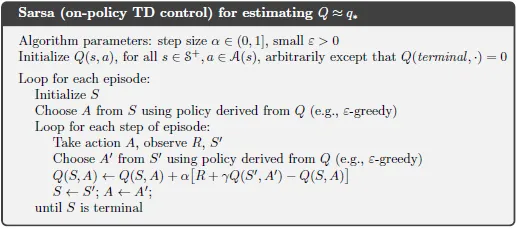


---

References: <br>
https://en.wikipedia.org/wiki/State–action–reward–state–action <br>
https://ikvibhav.medium.com/open-aigym-simple-sarsa-and-q-learning-reinforcement-learning-implementations-7d5ea6f1ff9

## Task 1: Development of an RL agent

In [ ]:
#Hyperparamters
EPISODES = 10000
DISCOUNT = 0.95
EPISODE_DISPLAY = 500
LEARNING_RATE = 0.25
EPSILON = 0.1

#Q-Table of size theta_state_size*theta_dot_state_size*env.action_space.n
theta_minmax = env.observation_space.high[2] 
theta_dot_minmax = math.radians(50)
theta_state_size = 50
theta_dot_state_size = 50
Q_TABLE = np.random.randn(theta_state_size,theta_dot_state_size,env.action_space.n)

# For stats
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

In [ ]:
def discretised_state(state):
	#state[2] -> theta
	#state[3] -> theta_dot
	discrete_state = np.array([0,0])		#Initialised discrete array
	theta_window =  ( theta_minmax - (-theta_minmax) ) / theta_state_size
	discrete_state[0] = ( state[2] - (-theta_minmax) ) // theta_window
	discrete_state[0] = min(theta_state_size-1, max(0,discrete_state[0]))

	theta_dot_window =  ( theta_dot_minmax - (-theta_dot_minmax) )/ theta_dot_state_size
	discrete_state[1] = ( state[3] - (-theta_dot_minmax) ) // theta_dot_window
	discrete_state[1] = min(theta_dot_state_size-1, max(0,discrete_state[1]))

	return tuple(discrete_state.astype(np.int))

The function below is used to create the SARSA agent. It takes 

In [ ]:
def sarsa_agent(state, q_table, epsilon):
    discrete_state = discretised_state(state)
    if np.random.random() > epsilon:
        action = np.argmax(q_table[discrete_state])
    else:
        action = np.random.randint(0, env.action_space.n)
    return action


In [ ]:
def train(env, episodes, discount, learning_rate, epsilon):
    q_table = np.random.randn(theta_state_size,theta_dot_state_size,env.action_space.n)
    ep_rewards = []
    for episode in range(episodes):
        episode_reward = 0
        done = False
        observation = env.reset()
        action = sarsa_agent(observation, q_table, epsilon)
        while not done:
            new_observation, reward, done, _ = env.step(action)
            new_action = sarsa_agent(new_observation, q_table, epsilon)
            episode_reward += reward
            current_q = q_table[discretised_state(observation)+(action,)]
            future_q = q_table[discretised_state(new_observation)+(new_action,)]
            new_q = current_q + learning_rate*(reward + discount*future_q - current_q)
            q_table[discretised_state(observation)+(action,)] = new_q
            observation = new_observation
            action = new_action
        ep_rewards.append(episode_reward)
    return q_table, ep_rewards


In [ ]:
def test(env, episodes):
    episode_rewards = []
    for episode in range(episodes):
        observation = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = sarsa_agent(observation, q_table, EPSILON)
            observation, reward, done, _ = env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)
    return episode_rewards


In [ ]:
q_table, ep_rewards = train(env, EPISODES, DISCOUNT, LEARNING_RATE, EPSILON)

<ipython-input-9-56ba1009eb8e>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


For Task 1, we can show the observation and chosen action below:

In [ ]:
#q_table, ep_rewards = train(env, EPISODES, DISCOUNT, LEARNING_RATE, EPSILON)
observation = env.reset()
action = sarsa_agent(observation, q_table, EPSILON)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.0303629  -0.00239823  0.02735173  0.02376028]
Chosen action: 0


<ipython-input-9-56ba1009eb8e>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [ ]:
episode_results = test(env, 100) #np.random.randint(150, 250, size=100)

<ipython-input-9-56ba1009eb8e>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))


100

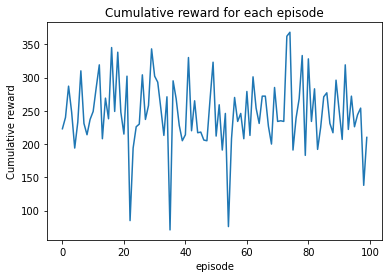

In [ ]:
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
average = sum(episode_results) / 100
print("Average cumulative reward:", average)
print("Is my agent good enough?", average > 195)

Average cumulative reward: 246.51
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = sarsa_agent(observation, q_table, EPSILON)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()

<ipython-input-9-56ba1009eb8e>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return tuple(discrete_state.astype(np.int))
